<h1><center><font size="25">Exploración de la demanda de tickets de avion </font></center></h1>

Este conjunto de datos proporciona totales mensuales de pasajeros de una aerolínea de EE. UU. desde 1949 hasta 1960. Este conjunto de datos se creó a partir de un conjunto de datos incorporado a R llamado AirPassengers


### Mission



El modelado de series de tiempo es un proceso de descomposición y representación de las relaciones estadísticas entre puntos de datos en el tiempo. Para que nuestro modelo se ajuste a nuestros datos y pronostique razonablemente, existen restricciones sobre las relaciones estadísticas en los datos que deben cumplirse. Esta notebook es una introducción al modelado de series de tiempo, la estacionariedad y cómo podemos descomponer y probar las relaciones estadísticas en nuestros datos antes de aplicar un modelo.

In [21]:
import itertools
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
warnings.filterwarnings('ignore')
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

In [22]:
df1 = pd.read_csv("AirPassengers.csv")

In [23]:
df = pd.read_csv("AirPassengers.csv", index_col='Month', parse_dates=True)

In [24]:
df.shape
df.columns

Index(['#Passengers'], dtype='object')

In [25]:
df1.columns


Index(['Month', '#Passengers'], dtype='object')

In [26]:
df.rename(columns={'#Passengers': 'Passengers'}, inplace=True)
df1.columns = ['Date','Number of Passengers']

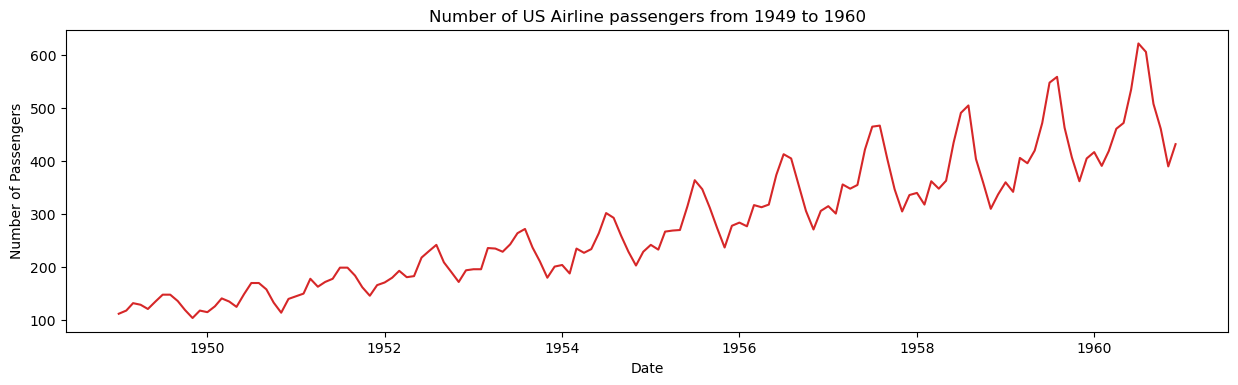

In [27]:

plt.figure(figsize=(15,4), dpi=100)
plt.plot(df[['Passengers']], color='tab:red')
plt.gca().set(title='Number of US Airline passengers from 1949 to 1960',xlabel='Date', ylabel='Number of Passengers')
plt.show()
    

Make train and test sets of data.

In [28]:
df.index.freq = "MS"
train = df[:120]
test = df[120:]


# Estacionaridad

Una serie temporal estacionaria es aquella cuyas propiedades estadísticas, como la media, la varianza y la autocovarianza, son todas constantes y no una función del tiempo.

Si podemos suponer que estas propiedades estadísticas no cambiarán con el tiempo, entonces podemos predecir que el futuro de la serie temporal tendrá las mismas propiedades estadísticas o proporcionales. 

Como resultado, la mayoría de los métodos estadísticos de predicción se basan en la suposición de que la serie temporal es aproximadamente estacionaria, pero la mayoría de las series temporales que veremos no lo son.

Los no estacionarios pueden provenir de cambios deterministas como la tendencia o las fluctuaciones estacionales, o porque las propiedades estocásticas del proceso tienen una raíz unitaria. En el primer caso podemos eliminar el componente determinístico, y en el segundo podemos probar la presencia de la raíz unitaria y diferenciarla. 

En esta notebook explorará algunas de las principales formas en que podemos descomponer, probar y procesar nuestra serie de tiempo. Encontrar la secuencia de transformaciones necesarias para estacionarizar una serie de tiempo a menudo brinda pistas importantes en la búsqueda de un modelo de pronóstico apropiado.

In [29]:
# Stability Test (Dickey-Fuller Test)
def is_stationary(y):

    # "HO: Non-stationary"
    # "H1: Stationary"

    p_value = sm.tsa.stattools.adfuller(y)[1]
    if p_value < 0.05:
        print(F"Result: Stationary (H0: non-stationary, p-value: {round(p_value, 3)})")
    else:
        print(F"Result: Non-Stationary (H0: non-stationary, p-value: {round(p_value, 3)})")

<a id='seasonality'></a>
# Estacionalidad
---
<a id='decomposition'></a>
### Descomposicion

Supongamos que una serie de tiempo dada consta de tres componentes sistemáticos que incluyen nivel, tendencia, estacionalidad y un componente aleatorio llamado ruido.

Estos componentes se definen de la siguiente manera:

- Nivel: El valor medio de la serie.

- Tendencia: El valor creciente o decreciente en la serie.

- Estacionalidad: El ciclo de corto plazo que se repite en la serie.

- Ruido: La variación aleatoria en la serie.



Una estacion es un período de tiempo fijo que contiene la repetición completa del patrón de su serie temporal. Preste mucha atención, sus datos pueden repetirse todos los días, pero si los fines de semana se ven diferentes a los días de la semana, entonces su temporada es una semana, no un día.

La descomposición de la estacionalidad es una herramienta de análisis que nos proporciona un marco sobre cómo pensar en los diferentes componentes de nuestra serie temporal. Podemos descomponer nuestra serie para comprender la influencia de cada componente y usar eso para guiar nuestra preparación de datos, selección de modelos y ajuste de modelos. Como vimos en la sección sobre suavizado exponencial, los modelos que consideran la estacionalidad frente a los que no tienen un efecto destacado en nuestra capacidad para pronosticar la serie.

Las herramientas de descomposición también se utilizan en la previsión mediante la eliminación de un componente, como la tendencia, de nuestra serie temporal antes del modelado y la previsión. Solo asegúrese de que si transforma los datos, invierta esa transformación antes de usar las predicciones de la serie.

La descomposición estacional en `statsmodels` solo requiere que indiquemos si el modelo es aditivo o multiplicativo.

Todas las series tienen nivel y ruido. Los componentes de tendencia y estacionalidad son opcionales. Es útil pensar en los componentes como si se combinaran de forma aditiva o multiplicativa.

Un modelo aditivo sugiere que los componentes se suman de la siguiente manera:

y(t) = Nivel + Tendencia + Estacionalidad + Ruido

Un modelo aditivo es lineal donde los cambios a lo largo del tiempo se realizan consistentemente en la misma cantidad. Una estacionalidad lineal tiene la misma frecuencia (ancho de ciclos) y amplitud (alto de ciclos).




Un modelo multiplicativo sugiere que los componentes se multiplican juntos de la siguiente manera:

y(t) = Nivel Tendencia Estacionalidad * Ruido

Un modelo multiplicativo es no lineal, como cuadrático o exponencial. Los cambios aumentan o disminuyen con el tiempo. Una estacionalidad no lineal tiene una frecuencia y/o amplitud creciente o decreciente a lo largo del tiempo.

La descomposición proporciona una forma estructurada de pensar sobre un problema de pronóstico de series de tiempo, tanto en términos generales de complejidad de modelado como específicamente en términos de cómo capturar mejor cada uno de estos componentes en un modelo dado.



Es posible que deba pensar y abordar cada uno de estos componentes durante la preparación de datos, la selección del modelo y el ajuste del modelo. Puede abordarlo explícitamente en términos de modelar la tendencia y restarla de sus datos, o implícitamente proporcionando suficiente historial para que un algoritmo modele una tendencia, si es que existe.

Para implementar el método de descomposición ingenuo o clásico, usamos el método season_decompose() proporcionado por la biblioteca statsmodels. Requiere que especifique si el modelo es Aditivo o Multiplicativo.

In [30]:
# Time Series Components and Stationarity Test
def ts_decompose(y, model="additive", stationary=False):
    result = seasonal_decompose(y, model=model)
    fig, axes = plt.subplots(4, 1, sharex=True, sharey=False)
    fig.set_figheight(10)
    fig.set_figwidth(15)

    axes[0].set_title("Decomposition for " + model + " model")
    axes[0].plot(y, 'k', label='Original ' + model)
    axes[0].legend(loc='upper left')

    axes[1].plot(result.trend, label='Trend')
    axes[1].legend(loc='upper left')

    axes[2].plot(result.seasonal, 'g', label='Seasonality & Mean: ' + str(round(result.seasonal.mean(), 4)))
    axes[2].legend(loc='upper left')

    axes[3].plot(result.resid, 'r', label='Residuals & Mean: ' + str(round(result.resid.mean(), 4)))
    axes[3].legend(loc='upper left')
    plt.show(block=True)

    if stationary:
        is_stationary(y)

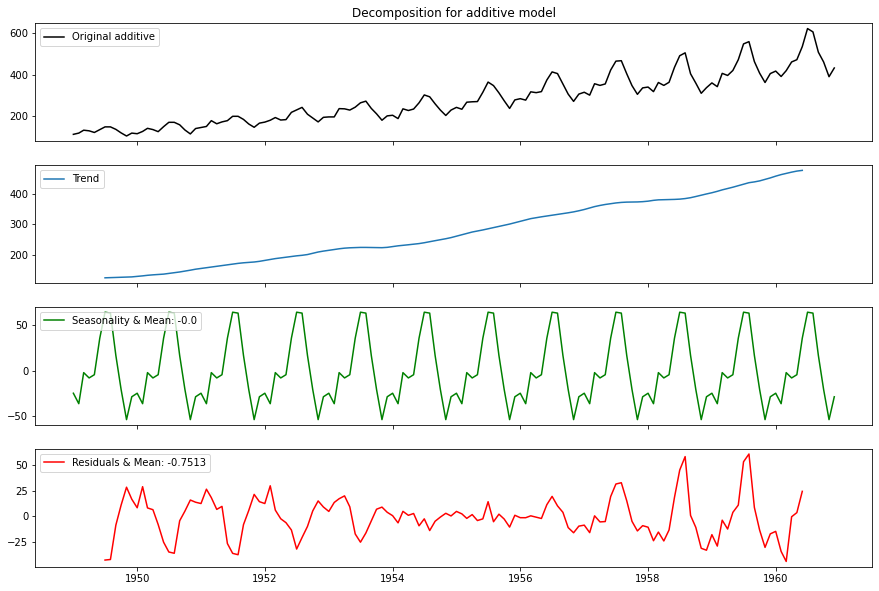

Result: Non-Stationary (H0: non-stationary, p-value: 0.992)


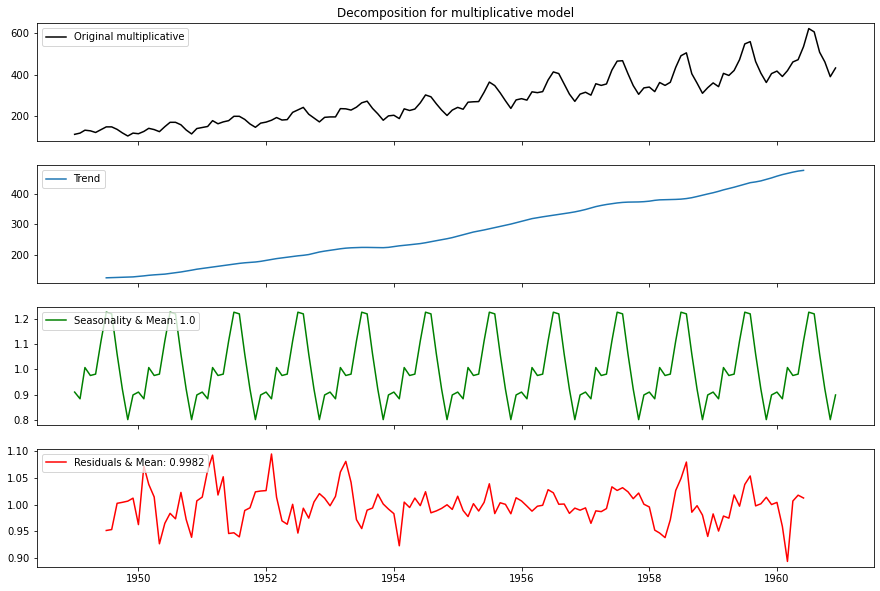

Result: Non-Stationary (H0: non-stationary, p-value: 0.992)


In [31]:
# Analysis for additive and multiplicative models
for model in ["additive", "multiplicative"]:
    ts_decompose(df, model,stationary=True)

<a id='smoothing'></a>
# Suavizado
---
 
El suavizado es una técnica que podemos utilizar para reducir el ruido en nuestra serie temporal y realizar pronósticos. El pronóstico con técnicas de suavizado como el suavizado exponencial lineal (LES) y el suavizado exponencial simple (SES) puede funcionar para datos no estacionales donde la serie temporal es estacionaria localmente y tiene una tendencia leve. Para series de tiempo más complejas, existen técnicas como los métodos estacionales de Holt-Winters que se basan en técnicas de suavizado simples. No profundizaremos mucho en los métodos de pronóstico de Holt-Winters, pero los presentaremos, presentaremos cómo se relacionan con técnicas más simples y, con suerte, entenderemos cómo pensar en nuestra serie de tiempo como una combinación de componentes y cómo el suavizado afecta la distribución subyacente. de nuestros datos.

Las técnicas de suavizado son fundamentales para las series temporales y se utilizan en varias aplicaciones, incluida la familia ARMA de modelos de pronóstico. Al suavizar, debemos prestar atención a la varianza y la forma de nuestras distribuciones de datos, ya que los modelos excesivamente suavizados pueden mostrar un alto sesgo, y el suavizado puede reducir demasiada varianza según nuestros parámetros.

<a id='sma'></a>

<a id='exp smoothing'></a>
### Simple Exponential Smoothing (SES)



El suavizado exponencial es un promedio ponderado de n términos de datos pasados, donde los pesos decaen exponencialmente. Podemos usar el suavizado exponencial simple cuando los datos no son estacionales y muestran una media variable en el tiempo sin una tendencia constante. SES es lo mismo que un modelo ARIMA(0, 1, 1) sin una constante estacional. Proporcionamos a SES un valor, alfa, un parámetro de suavizado que controla la velocidad a la que los pesos decaen exponencialmente. Los valores grandes significan que el modelo presta mucha atención a las observaciones pasadas más recientes, y un alfa más pequeño considera una historia mayor.

In [32]:
# Single Exponential Smoothing 

def ses_optimizer(train, alphas, step=48):
    best_alpha, best_mae = None, float("inf")
    for alpha in alphas:
        ses_model = SimpleExpSmoothing(train).fit(smoothing_level=alpha)
        y_pred = ses_model.forecast(step)
        mae = mean_absolute_error(test, y_pred)
        if mae < best_mae:
            best_alpha, best_mae = alpha, mae
        #print("alpha:", round(alpha, 2), "mae:", round(mae, 4))
    print("best_alpha:", round(best_alpha, 2), "best_mae:", round(best_mae, 4))
    return best_alpha, best_mae

alphas = np.arange(0.01, 1, 0.10)
best_alpha, best_mae = ses_optimizer(train, alphas, step=24)



best_alpha: 0.11 best_mae: 82.528


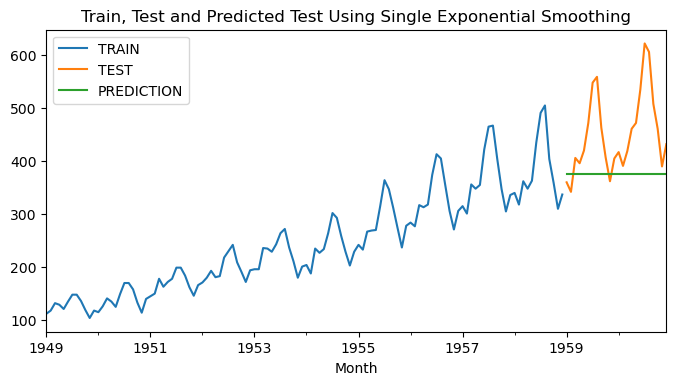

In [33]:
# alpha: 0.11 mae: 82.528

ses_model = SimpleExpSmoothing(train).fit(smoothing_level=best_alpha)
y_pred = ses_model.forecast(24)

def plot_prediction(y_pred, label):
    plt.figure(figsize=(8,4), dpi=100)
    train["Passengers"].plot(legend=True, label="TRAIN")
    test["Passengers"].plot(legend=True, label="TEST")
    y_pred.plot(legend=True, label="PREDICTION")
    plt.title("Train, Test and Predicted Test Using "+label)
    plt.show()

plot_prediction(y_pred, "Single Exponential Smoothing")


### Double Exponential Smoothing 

El suavizado exponencial doble es para analizar datos que muestran una tendencia, agrega ecuaciones adicionales al suavizado exponencial simple para capturar el nivel y la tendencia de la serie, utilizando el parámetro beta. 

El suavizado exponencial doble también se denomina método de tendencia lineal de Holt y en el paquete statsmodels usamos `ExponentialSmoothing` para implementar el suavizado exponencial doble y triple. 

Al usar el paquete statsmodels todo lo que tenemos que indicar es si la tendencia es aditiva o multiplicativa. Esto se discute más adelante en el núcleo, pero simplemente, la tendencia aditiva y multiplicativa se trata de si la tendencia es consistente o parece crecer, como una función exponencial, por ejemplo.

Si la tendencia es consistente entonces es aditiva, si la tendencia crece entonces es multiplicativa. También parte de la implementación de suavizado exponencial de statsmodels es un argumento `amortiguado`.

El método lineal de Holt tiende a mostrar una tendencia constante indefinidamente en el futuro. El parámetro `amortiguado` corrige esta tendencia infinita amortiguando la tendencia. Hay un parámetro amortiguado entre 0 y 1 donde los valores más cercanos a 1 son los mismos que en un modelo no amortiguado. Podemos establecer estos parámetros nosotros mismos, pero en la práctica, simplemente establecemos si incluir o no el parámetro amortiguado.

In [37]:
# Double Exponential Smoothing

def des_optimizer(train, alphas, betas, step=48):
    best_alpha, best_beta, best_mae = None, None, float("inf")
    for alpha in alphas:
        for beta in betas:
            des_model = ExponentialSmoothing(train, trend="add").fit(smoothing_level=alpha, smoothing_slope=beta)
            y_pred = des_model.forecast(step)
            mae = mean_absolute_error(test, y_pred)
            if mae < best_mae:
                best_alpha, best_beta, best_mae = alpha, beta, mae
            #print("alpha:", round(alpha, 2), "beta:", round(beta, 2), "mae:", round(mae, 4))
    print("best_alpha:", round(best_alpha, 2), "best_beta:", round(best_beta, 2), "best_mae:", round(best_mae, 4))
    return best_alpha, best_beta, best_mae


alphas = np.arange(0.01, 1, 0.10)
betas = np.arange(0.01, 1, 0.10)

best_alpha, best_beta, best_mae = des_optimizer(train, alphas, betas, step=24)
#54.10

des_model = ExponentialSmoothing(train, trend="add").fit(smoothing_level=best_alpha,
                                                         smoothing_slope=best_beta)
y_pred = des_model.forecast(24)



best_alpha: 0.01 best_beta: 0.11 best_mae: 54.1036


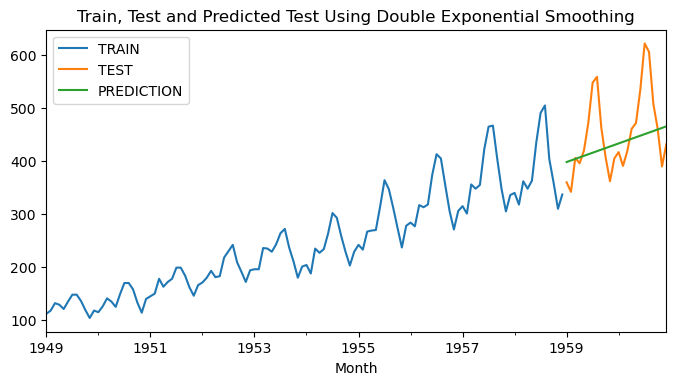

In [38]:

plot_prediction(y_pred, "Double Exponential Smoothing")


### Triple Exponential Smoothing

Si sus datos muestran tendencia y estacionalidad, el suavizado exponencial triple se basa en las ecuaciones utilizadas en simple y doble y agrega una tercera ecuación para manejar la estacionalidad. También llamado Holt-Winters Exponential Smoothing, un nuevo parámetro, gamma, se utiliza para influir en la estacionalidad. Además, indicamos si la estacionalidad es aditiva o multiplicativa como hicimos con la tendencia.

 

In [39]:
# Triple Exponential Smoothing (Holt-Winters)

def tes_optimizer(train, abg, step=48):
    best_alpha, best_beta, best_gamma, best_mae = None, None, None, float("inf")
    for comb in abg:
        tes_model = ExponentialSmoothing(train, trend="add", seasonal="add", seasonal_periods=12).\
            fit(smoothing_level=comb[0], smoothing_slope=comb[1], smoothing_seasonal=comb[2])
        y_pred = tes_model.forecast(step)
        mae = mean_absolute_error(test, y_pred)
        if mae < best_mae:
            best_alpha, best_beta, best_gamma, best_mae = comb[0], comb[1], comb[2], mae
        #print([round(comb[0], 2), round(comb[1], 2), round(comb[2], 2), round(mae, 2)])

    print("best_alpha:", round(best_alpha, 2), "best_beta:", round(best_beta, 2), "best_gamma:", round(best_gamma, 2),
          "best_mae:", round(best_mae, 4))

    return best_alpha, best_beta, best_gamma, best_mae

alphas = betas = gammas = np.arange(0.10, 1, 0.20)
abg = list(itertools.product(alphas, betas, gammas))

best_alpha, best_beta, best_gamma, best_mae = tes_optimizer(train, abg, step=24)
# 11.99
# carpımsal hata: 15.12

tes_model = ExponentialSmoothing(train, trend="add", seasonal="add", seasonal_periods=12).\
            fit(smoothing_level=best_alpha, smoothing_slope=best_beta, smoothing_seasonal=best_gamma)

y_pred = tes_model.forecast(24)




best_alpha: 0.3 best_beta: 0.3 best_gamma: 0.5 best_mae: 11.9947


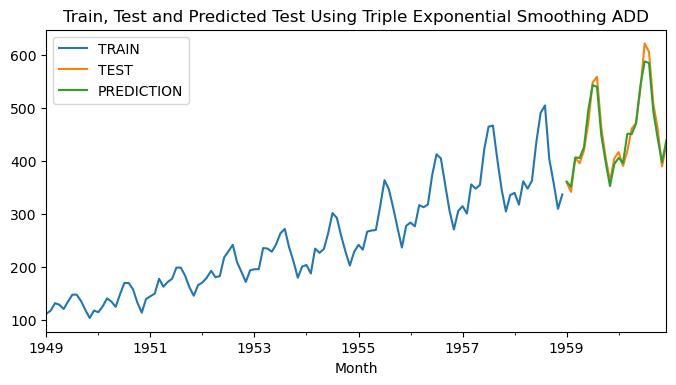

In [40]:
plot_prediction(y_pred, "Triple Exponential Smoothing ADD")


### Simple Moving Average (SMA)


El promedio móvil simple es un promedio igualmente ponderado de n términos de datos. El promedio móvil simple es excelente cuando faltan datos o son muy irregulares. Es primitivo pero robusto. 

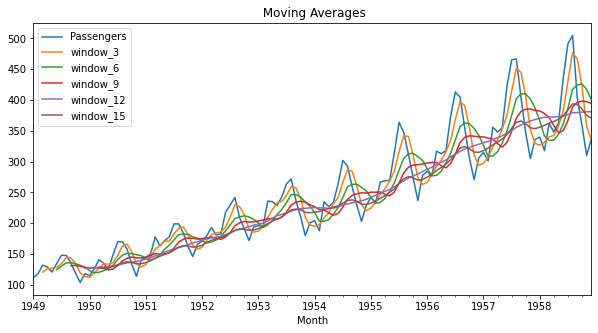

In [18]:
SMA_df= train
for n in range(1, 6):
    label = 'window_'+str(n*3)
    SMA_df[label] = SMA_df['Passengers'].rolling(window=n*3).mean()

SMA_df.plot(figsize=(10, 5), title=' Moving Averages')
plt.show()


# PARA HACER DESPUES DE VER ARIMA Y SARIMAX

In [41]:
df.index.freq = "MS"
train = df[:120]
test = df[120:]

In [42]:
# ARIMA(p, d, q): (Autoregressive Integrated Moving Average)

# p ve q kombinasyonlarının üretilmesi
p = d = q = range(0, 4)
pdq = list(itertools.product(p, d, q))

def arima_optimizer_aic(train, orders):
    best_aic, best_params = float("inf"), None
    for order in orders:
        try:
            arma_model_result = ARIMA(train, order).fit(disp=0)
            aic = arma_model_result.aic
            if aic < best_aic:
                best_aic, best_params = aic, order
            #print('ARIMA%s AIC=%.2f' % (order, aic))
        except:
            continue
    print('Best ARIMA%s AIC=%.2f' % (best_params, best_aic))
    return best_params

best_params_aic = arima_optimizer_aic(train, pdq)


# Tuned Model
arima_model = ARIMA(train, best_params_aic).fit(disp=0)
y_pred = arima_model.forecast(24)[0]
mean_absolute_error(test, y_pred)
# 51.18


Best ARIMA(3, 1, 3) AIC=1083.09


51.18063648730833

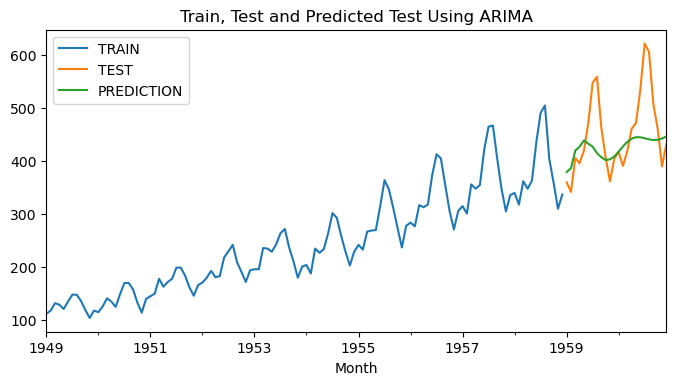

In [43]:

plot_prediction(pd.Series(y_pred, index=test.index), "ARIMA")

In [44]:
# SARIMA

p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]


def sarima_optimizer_aic(train, pdq, seasonal_pdq):
    best_aic, best_order, best_seasonal_order = float("inf"), float("inf"), None
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                sarimax_model = SARIMAX(train, order=param, seasonal_order=param_seasonal)
                results = sarimax_model.fit(disp=0)
                aic = results.aic
                if aic < best_aic:
                    best_aic, best_order, best_seasonal_order = aic, param, param_seasonal
                #print('SARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, aic))
            except:
                continue
    print('SARIMA{}x{}12 - AIC:{}'.format(best_order, best_seasonal_order, best_aic))
    return best_order, best_seasonal_order


best_order, best_seasonal_order = sarima_optimizer_aic(train, pdq, seasonal_pdq)

# Tuned Model
model = SARIMAX(train, order=best_order, seasonal_order=best_seasonal_order)
sarima_final_model = model.fit(disp=0)
y_pred_test = sarima_final_model.get_forecast(steps=24)
# pred_ci = y_pred_test.conf_int()
y_pred = y_pred_test.predicted_mean
mean_absolute_error(test, y_pred)
# 63.8447




SARIMA(1, 1, 0)x(0, 1, 0, 12)12 - AIC:803.2812826905404


68.57726545235921

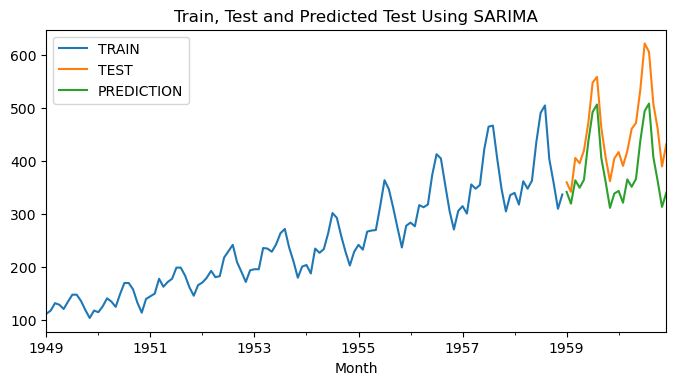

In [45]:
plot_prediction(pd.Series(y_pred, index=test.index), "SARIMA")


In [47]:



p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

def sarima_optimizer_mae(train, pdq, seasonal_pdq):
    best_mae, best_order, best_seasonal_order = float("inf"), float("inf"), None

    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                model = SARIMAX(train, order=param, seasonal_order=param_seasonal)
                sarima_model = model.fit(disp=0)
                y_pred_test = sarima_model.get_forecast(steps=24)
                y_pred = y_pred_test.predicted_mean
                mae = mean_absolute_error(test, y_pred)

                # mae = fit_model_sarima(train, val, param, param_seasonal)

                if mae < best_mae:
                    best_mae, best_order, best_seasonal_order = mae, param, param_seasonal
                #print('SARIMA{}x{}12 - MAE:{}'.format(param, param_seasonal, mae))
            except:
                continue
    print('SARIMA{}x{}12 - MAE:{}'.format(best_order, best_seasonal_order, best_mae))
    return best_order, best_seasonal_order, best_mae

best_order, best_seasonal_order, best_mae = sarima_optimizer_mae(train, pdq, seasonal_pdq)

model = SARIMAX(train, order=best_order, seasonal_order=best_seasonal_order)
sarima_final_model = model.fit(disp=0)
y_pred_test = sarima_final_model.get_forecast(steps=24)
y_pred = y_pred_test.predicted_mean
mean_absolute_error(test, y_pred)


SARIMA(0, 0, 0)x(1, 1, 1, 12)12 - MAE:30.620239479819503


30.620239479819503

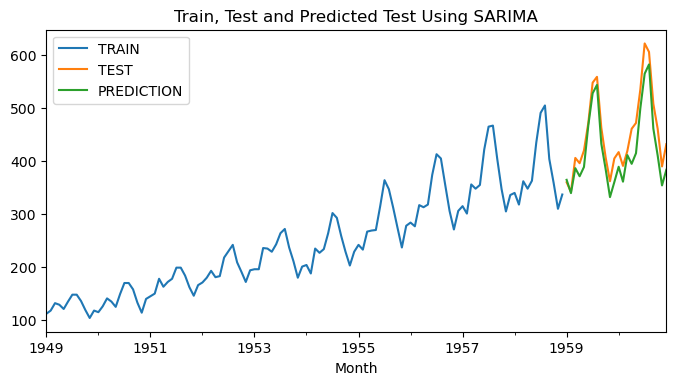

In [26]:
plot_prediction(pd.Series(y_pred, index=test.index), "SARIMA")

- **SARIMA(0, 0, 0)x(1, 1, 1, 12)12 - MAE:30.626157879495242**